<a href="https://colab.research.google.com/github/genuguru/IT7143_Cloud-Analytics/blob/main/RP_Ecommerce_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Step 1: Set up Google Colab and import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [34]:
# Step 2: Load the dataset
df = pd.read_csv('ecommercetransactiondata.csv')

In [35]:
# Display the first few rows of the DataFrame
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,82524861-a7dd-4568-9461-4b23861d23e5,85260418-6c62-4518-920b-5f88d0b17cfa,478.65,2024-03-25 00:10:18,bank transfer,health & beauty,5,47,East Emilyfort,desktop,175.140.189.68,"16404 Robin Haven\nLake Samantha, ND 71966","457 Caitlin Square Suite 304\nKevinberg, AK 92365",1,21,0
1,3ddb72e2-081a-416d-a8fe-d1cca60e82f3,4660035d-66aa-4992-bb43-b103d9b8cc66,54.04,2024-03-25 18:09:07,credit card,health & beauty,3,49,Howardbury,desktop,5.210.225.78,"77563 Tyler Pike\nNorth Ericstad, FL 37383","77563 Tyler Pike\nNorth Ericstad, FL 37383",0,102,18
2,6ab35948-69e6-4542-84fd-8e6f830e4e31,e8b202b8-f7c6-4300-8c3c-59c57ae5107a,87.76,2024-01-11 06:03:12,debit card,home & garden,1,34,West Gary,tablet,177.224.251.167,"63762 Steven Green Apt. 303\nLake Joshua, PA 2...","63762 Steven Green Apt. 303\nLake Joshua, PA 2...",0,94,6
3,c37361de-c4d2-447b-96a9-d37297a708b5,34541c91-cd0e-46ca-b17c-7982f5997c55,91.35,2024-03-18 02:02:18,PayPal,clothing,2,38,South Tammy,tablet,220.58.239.255,"887 Ross Passage Apt. 127\nDanielview, DE 57092","887 Ross Passage Apt. 127\nDanielview, DE 57092",0,34,2
4,155755eb-d091-4154-b7a1-b5eaa12c5c9f,b58c4818-4bcb-45a0-a14b-696da1d148bf,443.12,2024-02-10 02:34:17,PayPal,clothing,1,43,Monroeshire,tablet,222.139.201.30,"81341 Paul Village Apt. 228\nSouth Emily, AK 0...","81341 Paul Village Apt. 228\nSouth Emily, AK 0...",1,256,2


In [36]:
# Step 3: Data Preprocessing
# Remove the target column from the list of columns
target_column = 'Is Fraudulent'  # Replace with the actual target column name
if target_column in df.columns:
    df_features = df.drop(columns=[target_column])
else:
    df_features = df

# Separate numeric and non-numeric columns
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
non_numeric_cols = df_features.select_dtypes(exclude=[np.number]).columns

# Fill missing values in numeric columns with the median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing values in non-numeric columns with the mode
#df[non_numeric_cols] = df[non_numeric_cols].fillna(df[non_numeric_cols].mode().iloc[0])

# Convert categorical columns to numerical
df = pd.get_dummies(df, drop_first=True)



In [37]:
# Step 4: Check Class Distribution
print(df[target_column].value_counts())

Is Fraudulent
1    5000
0    5000
Name: count, dtype: int64


In [38]:
# Step 5: Exploratory Data Analysis (EDA)
# Basic statistics
print(df.describe())


       Transaction Amount      Quantity  Customer Age  Is Fraudulent  \
count        10000.000000  10000.000000  10000.000000   10000.000000   
mean           388.664424      3.010300     34.241000       0.500000   
std            594.929562      1.425832     10.002776       0.500025   
min             10.000000      1.000000     -6.000000       0.000000   
25%             83.497500      2.000000     27.000000       0.000000   
50%            193.465000      3.000000     34.000000       0.500000   
75%            409.217500      4.000000     41.000000       1.000000   
max           7037.150000      5.000000     67.000000       1.000000   

       Account Age Days  Transaction Hour  
count      10000.000000      10000.000000  
mean         149.889600          9.757300  
std          115.233798          7.203984  
min            1.000000          0.000000  
25%           29.000000          3.000000  
50%          139.000000          9.000000  
75%          249.000000         16.000000  

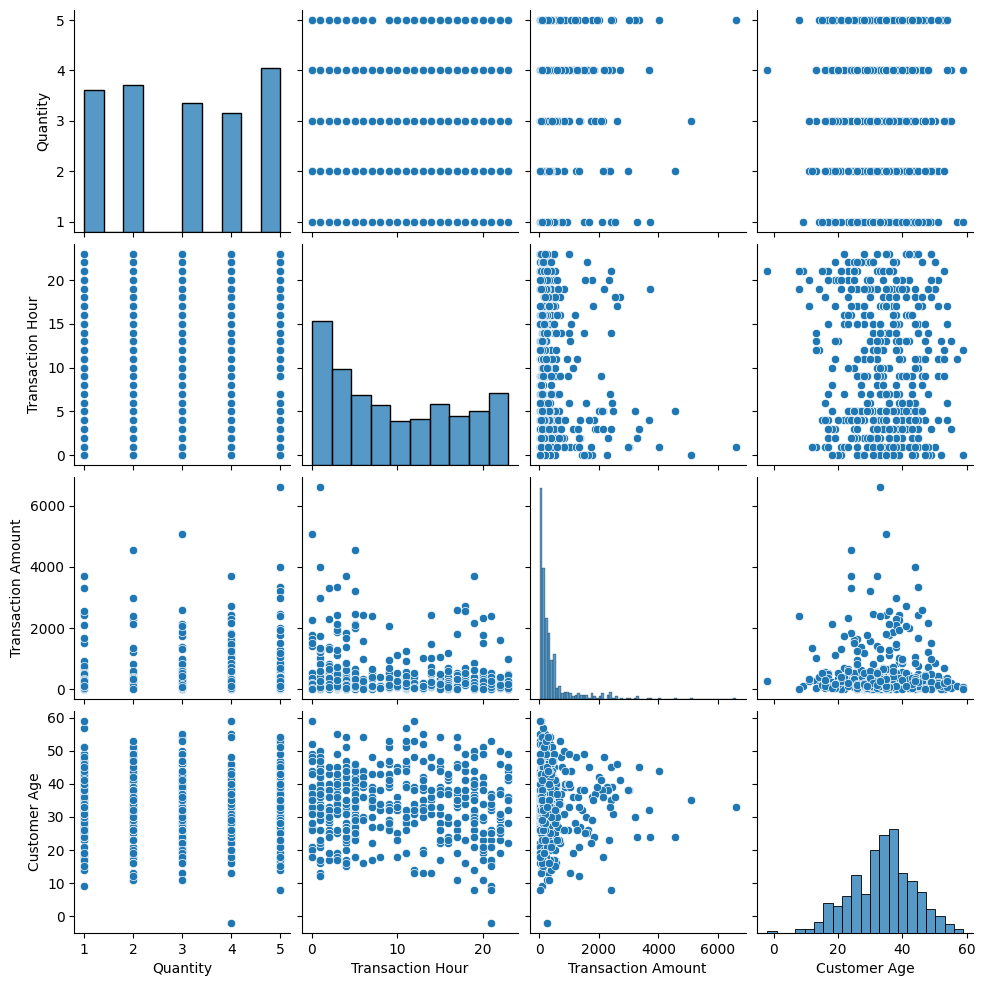

In [39]:
# Visualize data distribution
# Select a smaller number of important features for the pairplot
important_features = ['Quantity', 'Transaction Hour', 'Transaction Amount', 'Customer Age']

# Sample a smaller subset of the data focusing on important features
df_sample = df.sample(n=500, random_state=42)[important_features]

# Create pairplot with selected important features
sns.pairplot(df_sample)
plt.show()

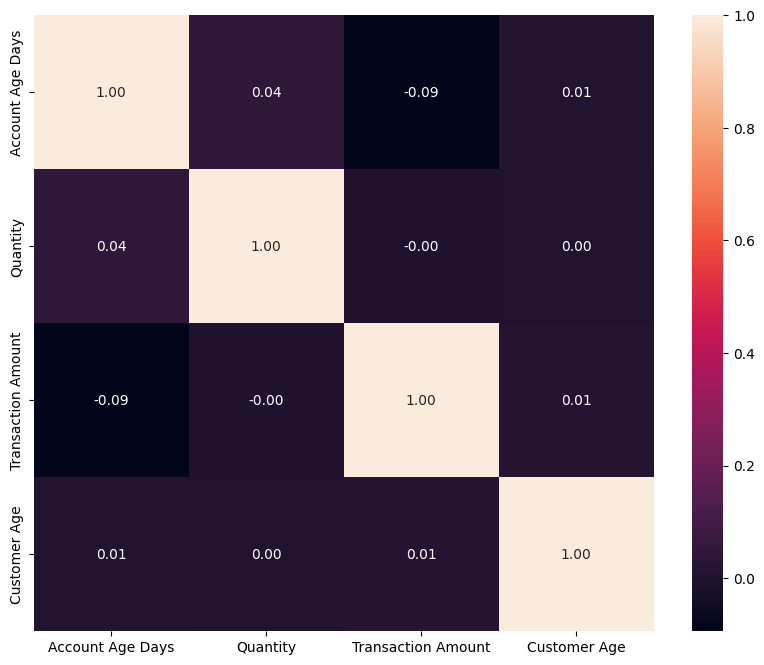

In [40]:
# Select a smaller number of important features for the correlation matrix
important_features = ['Account Age Days', 'Quantity', 'Transaction Amount', 'Customer Age']

# Calculate the correlation matrix for the selected important features
plt.figure(figsize=(10, 8))
sns.heatmap(df[important_features].corr(), annot=True, fmt='.2f')
plt.show()

In [41]:
# Step 6: Model Selection and Training

# Use a smaller subset for training to debug
df_small = df.sample(n=10000, random_state=42)

# Split the data into training and testing sets
X = df_small.drop('Is Fraudulent', axis=1)  # Assuming 'fraud' is the target column
y = df_small['Is Fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier with parallel processing
model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)  # Adjust n_estimators as needed
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [42]:
# Step 7: Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

Streaming output truncated to the last 5000 lines.
62720. feature 49179 (0.0)
62721. feature 14129 (0.0)
62722. feature 14130 (0.0)
62723. feature 14131 (0.0)
62724. feature 49173 (0.0)
62725. feature 49167 (0.0)
62726. feature 14134 (0.0)
62727. feature 14135 (0.0)
62728. feature 49128 (0.0)
62729. feature 14171 (0.0)
62730. feature 47576 (0.0)
62731. feature 49126 (0.0)
62732. feature 49095 (0.0)
62733. feature 49093 (0.0)
62734. feature 49087 (0.0)
62735. feature 49086 (0.0)
62736. feature 49085 (0.0)
62737. feature 49082 (0.0)
62738. feature 49080 (0.0)
62739. feature 49078 (0.0)
62740. feature 49077 (0.0)
62741. feature 14220 (0.0)
62742. feature 65813 (0.0)
62743. feature 14223 (0.0)
62744. feature 65814 (0.0)
62745. feature 49066 (0.0)
62746. feature 14228 (0.0)
62747. feature 49065 (0.0)
62748. feature 49061 (0.0)
62749. feature 49060 (0.0)
62750. feature 49059 (0.0)
62751. feature 49051 (0.0)
62752. feature 49049 (0.0)
62753. feature 49048 (0.0)
62754. feature 14238 (0.0)
6275

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      1490
           1       0.77      0.66      0.71      1510

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.73      0.73      0.73      3000

[[1190  300]
 [ 520  990]]
ROC-AUC Score: 0.8020498688830615


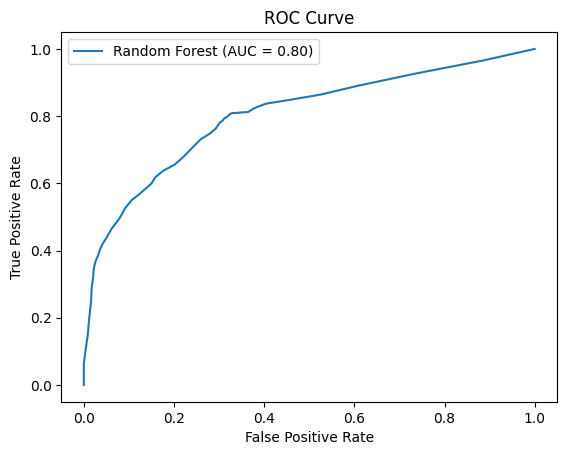

In [43]:
# Step 8: Model Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# ROC-AUC Score
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [44]:
# Step 9: Load and Preprocess New Transactions
# Example: Load new transactions from a CSV file
new_transactions = pd.read_csv('newtransactions.csv')

# Ensure 'fraud' column is not present
if 'Is Fraudulent' in new_transactions.columns:
    new_transactions = new_transactions.drop(columns=['Is Fraudulent'])

# Check for missing values and handle them as needed
# Filter columns to those present in the new_transactions dataframe
numeric_cols_new = [col for col in numeric_cols if col in new_transactions.columns]
non_numeric_cols_new = [col for col in non_numeric_cols if col in new_transactions.columns]

new_transactions[numeric_cols_new] = new_transactions[numeric_cols_new].fillna(new_transactions[numeric_cols_new].median())

if non_numeric_cols_new:  # Check if non-numeric columns are present
    new_transactions[non_numeric_cols_new] = new_transactions[non_numeric_cols_new].fillna(new_transactions[non_numeric_cols_new].mode().iloc[0])

# Convert categorical columns to numerical (same as training data)
new_transactions = pd.get_dummies(new_transactions, drop_first=True)

# Ensure the new transactions DataFrame has the same columns as the training data
missing_cols = set(X.columns) - set(new_transactions.columns)
missing_cols_df = pd.DataFrame(0, index=new_transactions.index, columns=list(missing_cols))
new_transactions = pd.concat([new_transactions, missing_cols_df], axis=1)

# Reorder the columns to match the training data
new_transactions = new_transactions[X.columns]

In [45]:
# Step 10: Scale the new transactions using the same scaler as the training data
new_transactions_scaled = scaler.transform(new_transactions)

In [46]:
# Step 11: Predict fraud for each transaction in a loop
def predict_fraud(transaction):
    transaction = pd.DataFrame([transaction])
    transaction = scaler.transform(transaction)
    prediction = model.predict(transaction)
    return prediction

predictions = []
for i, transaction in new_transactions.iterrows():
    pred = predict_fraud(transaction)
    predictions.append(pred[0])

# Display predictions
for i, pred in enumerate(predictions):
    print(f"Transaction {i}: {'Fraudulent' if pred else 'Not Fraudulent'}")

Transaction 0: Not Fraudulent
Transaction 1: Not Fraudulent
Transaction 2: Not Fraudulent
Transaction 3: Not Fraudulent
Transaction 4: Not Fraudulent
Transaction 5: Fraudulent
Transaction 6: Not Fraudulent
Transaction 7: Fraudulent
Transaction 8: Not Fraudulent
Transaction 9: Fraudulent
Transaction 10: Not Fraudulent
Transaction 11: Not Fraudulent
Transaction 12: Not Fraudulent
Transaction 13: Not Fraudulent
Transaction 14: Not Fraudulent
Transaction 15: Not Fraudulent
Transaction 16: Not Fraudulent
Transaction 17: Not Fraudulent
Transaction 18: Not Fraudulent
Transaction 19: Not Fraudulent
Transaction 20: Not Fraudulent
Transaction 21: Not Fraudulent
Transaction 22: Not Fraudulent
Transaction 23: Not Fraudulent
Transaction 24: Fraudulent
Transaction 25: Not Fraudulent
Transaction 26: Not Fraudulent
Transaction 27: Not Fraudulent
Transaction 28: Fraudulent
Transaction 29: Not Fraudulent
Transaction 30: Fraudulent
Transaction 31: Fraudulent
Transaction 32: Not Fraudulent
Transaction 33: